In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import tensorflow as tf

In [2]:
from keras.preprocessing.image import load_img, img_to_array

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import random

In [4]:
import imgaug.augmenters as iaa

In [5]:
import cv2

In [6]:
img_width, img_height = 216, 384

In [7]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 7
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

In [8]:
aug1 = iaa.GaussianBlur(sigma=(0, 0.5))
aug2 = iaa.AdditiveGaussianNoise(scale=(0, 0.01 * 255))
transorfm_aug = iaa.PerspectiveTransform(scale=(0.001, 0.15))
affine = iaa.Affine(scale=(0.5, 1.5))

def additional_augmenation(image):
    image = aug1.augment_image(image)
    image = aug2.augment_image(image)
    #image = transorfm_aug.augment_image(image)
    #image = affine.augment_image(image)
    return image

In [7]:
def preprocess_fcn(img):
    img = add_noise(img)
    return AHE(img)

def rotate_image(img):
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    return img

In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #rescale=1./255,
    #zoom_range=0.15,
    #shear_range=0.15,
    #rotation_range = 40,
    #brightness_range = (0.5, 2),
    validation_split=0.05,
    horizontal_flip = True,
    #rescale = 1.0/255.0

    #preprocessing_function=additional_augmenation,
)

val = tf.keras.preprocessing.image.ImageDataGenerator(    
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #rescale=1./255,
    #zoom_range=0.15,
    #shear_range=0.15,
    #rotation_range = 40,
    #brightness_range = (0.5, 2),
    validation_split=0.05,
    #horizontal_flip = True,
    #rescale = 1.0/255.0

    #preprocessing_function=additional_augmenation,
)

In [13]:
class_names = ['wada banderoli', 'wada nakretki', 'prawidlowa']

In [14]:
my_seed = 11123

TRAIN_DIR = "../../dataset/bottle_top_train"

#train_generator = datagen.flow_from_directory('processed_dataset/nowy', batch_size=32, class_mode='categorical', seed = 123, subset='training', classes=class_names, shuffle=True)
train_generator = datagen.flow_from_directory(TRAIN_DIR, (img_height, img_width), batch_size=32, class_mode='categorical', seed = my_seed, subset='training', classes=class_names, shuffle=True)
val_generator = val.flow_from_directory(TRAIN_DIR, (img_height, img_width), batch_size=32, class_mode='categorical', seed = my_seed, subset='validation', classes=class_names, shuffle=True)

Found 114 images belonging to 3 classes.
Found 6 images belonging to 3 classes.


In [15]:
from collections import Counter

print("Training")
print(train_generator.class_indices)
print(Counter(train_generator.classes))
print("Validation")
print(val_generator.class_indices)
print(Counter(val_generator.classes))

num_classes = len(class_names)

Training
{'wada banderoli': 0, 'wada nakretki': 1, 'prawidlowa': 2}
Counter({1: 57, 0: 38, 2: 19})
Validation
{'wada banderoli': 0, 'wada nakretki': 1, 'prawidlowa': 2}
Counter({1: 3, 0: 2, 2: 1})


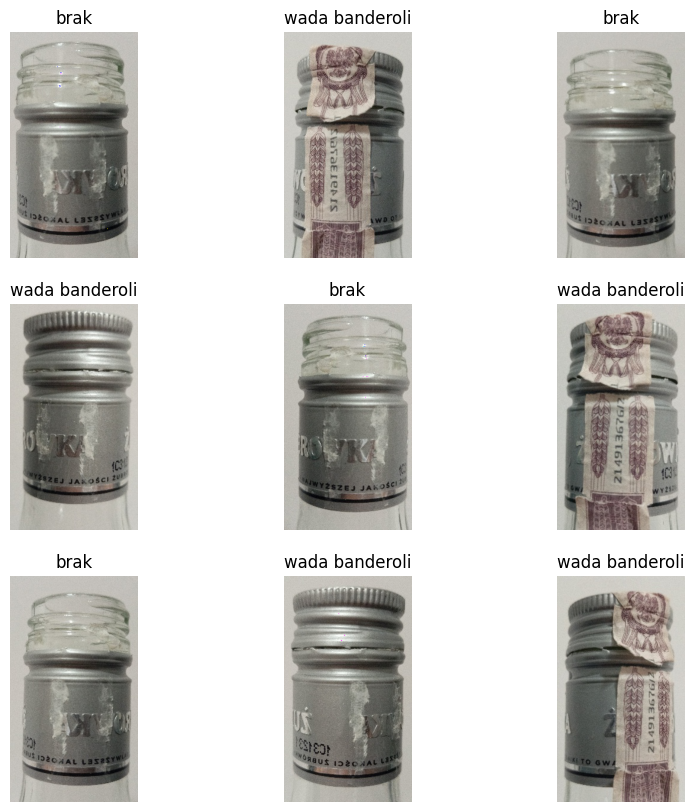

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for gen in range(3):
    x,y = train_generator.next()

    for i in range(3):
        ax = plt.subplot(3, 3, gen * 3 + i + 1)
        plt.imshow(x[i].astype("uint8"))
        plt.title(class_names[np.argmax(y[i])])
        plt.axis("off")

plt.show()

In [15]:
def create_model(num_classes):

    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D(2, 2),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        #Dropout(0.5),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.summary()

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])
    
    return model

In [22]:
model = create_model(num_classes)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 382, 214, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 191, 107, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 189, 105, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 94, 52, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 92, 50, 64)        18496     
                                                                 
 conv2d_23 (Conv2D)          (None, 90, 48, 64)       

In [23]:
epochs = 10

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='nasze.{epoch:02d}-{val_loss:.2f}.h5'),
]

history=model.fit(train_generator, epochs=epochs, callbacks=my_callbacks, validation_data=val_generator)

Epoch 1/10
26/26 [==============================] - 50s 2s/step - loss: 1.8757 - accuracy: 0.4451 - val_loss: 0.7220 - val_accuracy: 0.7500
Epoch 2/10
26/26 [==============================] - 46s 2s/step - loss: 0.5619 - accuracy: 0.8756 - val_loss: 0.4156 - val_accuracy: 0.8750
Epoch 3/10
26/26 [==============================] - 46s 2s/step - loss: 0.3184 - accuracy: 0.9146 - val_loss: 1.1387 - val_accuracy: 0.6750
Epoch 4/10
26/26 [==============================] - 45s 2s/step - loss: 0.2816 - accuracy: 0.9049 - val_loss: 0.4995 - val_accuracy: 0.8000
Epoch 5/10
26/26 [==============================] - 45s 2s/step - loss: 0.0977 - accuracy: 0.9671 - val_loss: 0.8884 - val_accuracy: 0.7250
Epoch 6/10
26/26 [==============================] - 45s 2s/step - loss: 0.1234 - accuracy: 0.9549 - val_loss: 0.4150 - val_accuracy: 0.9250
Epoch 7/10
26/26 [==============================] - 46s 2s/step - loss: 0.0813 - accuracy: 0.9878 - val_loss: 0.1395 - val_accuracy: 0.9250
Epoch 8/10
26/26 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


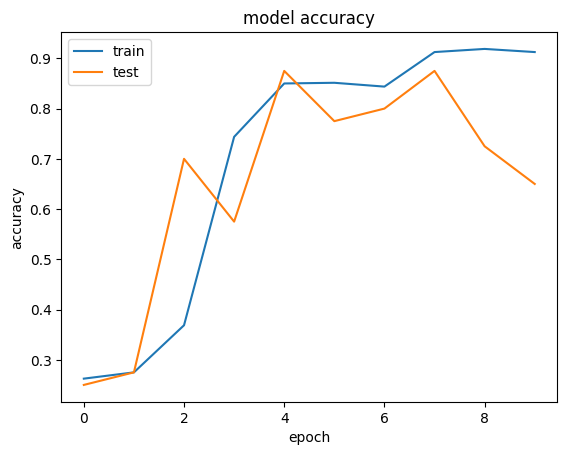

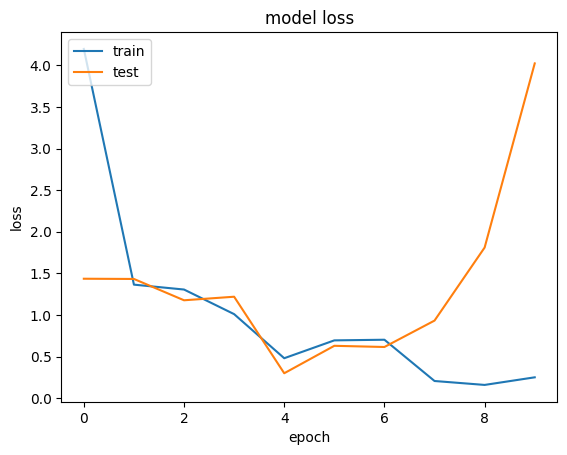

In [18]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
plt.imshow(X[0])

NameError: name 'X' is not defined

In [ ]:
from PIL import Image

In [ ]:
def make_prediction(src, model, show_image):
    for root, subdirs, files in os.walk(src):
        for images in files:
            img = Image.open(root + images)
            img = img.resize((img_width, img_height))
            if(show_image):
                img.show()
            #img = np.array(img).astype('float32')
            #img = img / 255.0
            X_to_predict = np.expand_dims(img, axis=0)
            y_pred = model.predict(X_to_predict)[0]
            prediction_class = y_pred.argmax()
            prediction_confidence = y_pred[prediction_class]
            
            print(prediction_class)
            print(prediction_confidence)
            print(class_names[prediction_class])
            print(y_pred)
            

print(class_names)

In [ ]:
model.save('nowa.h5')

In [ ]:
from keras.models import load_model

# Do odczytu

In [ ]:
model2 = load_model('trening_91.h5')

In [ ]:
make_prediction('dataset/testy_butelka/Puste/', model, True)